<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from pyspark.sql import SparkSession

*Để trực quan hóa dữ liệu, ta cần cài đặt thư viện matplotlib của python*  
Mở một terminal của jupyterlab và cài đặt matplotlib  

In [26]:
!pip install matplotlib

Để kết nối với kafka, ta cần khai báo các dependencies tương ứng như trong hình trên.  

Juputer lab là một container chạy trong môi trường docker, nên để truy cập đến spark-master, nó cần khai báo địa chỉ của spark trong môi trường docker, là spark://spark-master:7077, còn nếu notebook của ta chạy ở loalhost thì địa chỉ spark tương ứng với nó sẽ là spark://localhost:7077

*Sau khi kết nối được với spark thông qua spark context, mở trang localhost:8080 sẽ thấy một job đang chạy*  

In [2]:
packages = ["org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.1",
            "org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.1"]
packages = ",".join(packages)

# master = "spark://spark-master:7077"
master = "local"
appName = "sparkTest"

spark = SparkSession.builder.master(master).appName(appName).config("spark.jars.packages", packages).getOrCreate()

# spark = SparkSession.builder \
#                     .master(master) \
#                     .appName(appName) \
#                     .config("spark.jars.packages", packages) \
#                     .config("spark.executor.memory", "1024m") \
#                     .config("spark.executor.core", "1") \
#                     .getOrCreate()

spark

Chạy chương trình logger trong scripts/run-logger.sh để thực hiện streaming dữ liệu (Như trong file readMe có mô tả).  
Dùng spark để nhận dữ liệu được streaming từ kafka.  
*Do chương trình jupyterlab của chúng ta chạy trong môi trường docker, nên các địa chỉ của kafka bootstrap server cũa phải là trong môi trường docker, tức là kafka:9093, còn nếu notebook chạy ở localhost thì địa chỉ kafka sẽ là localhost:9092*

In [3]:
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:9093, kafka1:9093, localhost:9092") \
  .option("subscribe", "TASK-EVENT") \
  .option("startingOffsets", "earliest") \
  .load()

In [4]:
from pyspark.sql.functions import col, udf, split, mean
from pyspark.sql import Row, DataFrame

Trích xuất các thông tin cần thiết từ dữ liệu và ghi vào bộ nhớ ram ở dạng temporary table

In [5]:
value = df.select(col("value").cast("string").alias("Value"))
split_col = split(col("Value"), ",")
extract_task = value.select(split_col.getItem(0).cast("int").alias('id'),
                            split_col.getItem(5).cast("int").alias("machineId"),
                            split_col.getItem(6).cast("int").alias("eventType"),
                            split_col.getItem(9).cast("int").alias("priority"),
                            split_col.getItem(10).cast("float").alias("cpuRequest"),
                            split_col.getItem(11).cast("float").alias("memoryRequest"),
                            split_col.getItem(12).cast("float").alias("diskspaceRequest"))
mean_query = extract_task.select(mean(col("cpuRequest")).alias("mean_cpu_request"),
                                 mean(col("memoryRequest")).alias("mean_memory_request"),
                                 mean(col("diskspaceRequest")).alias("mean_diskspace_request")) \
                         .writeStream \
                         .format("memory") \
                         .queryName("mean") \
                         .outputMode("update") \
                         .start()

In [6]:
spark.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |     mean|       true|
+--------+---------+-----------+



In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

Lấy dữ liệu từ query mà ta lưu vào memory rồi thực hiện visualize.  
Chú ý, do dữ liệu dạng streaming nên khi đang streaming thì dữ liệu được visualize sẽ thay đổi, để thấy được nó thì ta thực hiện chạy lại cell của notebook (ctrl+Enter)

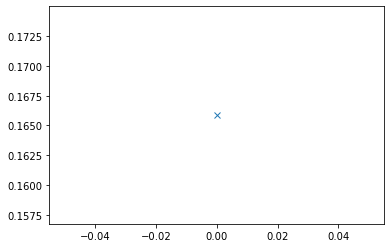

In [68]:
data = spark.sql("select * from mean")
x = data.rdd.map(lambda x: x['mean_cpu_request']).collect()
plt.plot(range(len(x[-1000:])), x[-1000:], 'x-')

In [15]:
data.show()

+-------------------+-------------------+----------------------+
|   mean_cpu_request|mean_memory_request|mean_diskspace_request|
+-------------------+-------------------+----------------------+
|0.16587276483042007|0.13713490579636795|   0.09993903366365593|
+-------------------+-------------------+----------------------+



## Machine attributes

In [16]:
machine_event_path = "/media/quangkhanh/E/google_data/clusterdata-2011-2/machine_events/part-00000-of-00001.csv"

In [17]:
machine_event = spark.read.option("header", "true").csv(machine_event_path)
machine_event.show(3)

+----+----------+----------+--------------------+----+------+
|time|machine_id|event_type|         platform_id|cpus|memory|
+----+----------+----------+--------------------+----+------+
|   0|         5|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|         6|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
|   0|         7|         0|HofLGzk1Or/8Ildj2...| 0.5|0.2493|
+----+----------+----------+--------------------+----+------+
only showing top 3 rows



In [32]:
machine_attribute = machine_event.groupBy("machine_id") \
                                    .agg(max("cpus").alias("cpu"),
                                         max("memory").alias("memory"))
machine_attribute.show(4)

+----------+---+------+
|machine_id|cpu|memory|
+----------+---+------+
|1018836875|0.5|0.2493|
|   1267344|0.5|0.4995|
|   1269279|0.5|0.4995|
|   1326698|0.5|0.4995|
+----------+---+------+
only showing top 4 rows



In [18]:
machine_event.printSchema()

root
 |-- time: string (nullable = true)
 |-- machine_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- platform_id: string (nullable = true)
 |-- cpus: string (nullable = true)
 |-- memory: string (nullable = true)



In [19]:
from pyspark.sql.functions import max, min, col, count, sum

In [ ]:
machine_request = extract_task.select("cpuRequest", "memoryRequest", "machineId") \
                                .groupBy("machineId") \
                                .agg(sum("cpuRequest").alias("cpu_request"), sum("memoryRequest").alias("memory_request"))
machine_status = machine_request.join(machine_attribute, machine_request.machineId == machine_attribute.machine_id, how="inner")
machine_status.writeStream \
            .format("memory") \
            .queryName("machine_request") \
            .outputMode("complete") \
            .start()

In [67]:
cpu_machine = spark.sql("select machine_id, cast (cpu_request as float), cast(cpu as float) from machine_request")
cpu_machine.show(3)

+----------+-----------+---+
|machine_id|cpu_request|cpu|
+----------+-----------+---+
| 451152936| 0.16304363|0.5|
|1436671113|0.115835555|0.5|
| 317468392| 0.26018032|0.5|
+----------+-----------+---+
only showing top 3 rows



In [52]:
from pyspark.sql.functions import udf, array
from pyspark.sql.types import IntegerType, FloatType

In [53]:
divide_col = udf(lambda arr: arr[0] / arr[1], FloatType())

In [59]:
cpu_request_percentage = cpu_machine.dropna().withColumn("%request", divide_col(array("cpu_request", "cpu")))

In [64]:
import seaborn as sns

<AxesSubplot:>

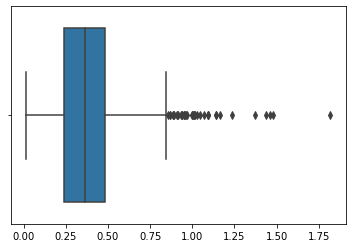

In [66]:
sns.boxplot(x=cpu_request_percentage.select("%request").rdd.map(lambda x: x[0]).collect())